In [ ]:
##  http://ocelma.net/software/python-recsys/build/html/algorithm.html
##  http://ocelma.net/software/python-recsys/build/html/quickstart.html

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import os,re
import numpy as np
import pandas as pd
import math
import sys
from recsys.algorithm.factorize import SVD

sys.stdout.flush()

In [117]:
##
## Load test and train sets for MovieLens_db
##

def loadMovieLens_train_test(path='data/movielens', k = 1):
    
# Получить названия фильмов
    movies={}
    for line in open(path+'/u.item'):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
# Загрузить данные
    prefs_train={}
    prefs_test={}
    
    print (path+'/u' + str(k) + '.base')
    for line in open(path+'/u' + str(k) + '.base'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs_train.setdefault(user,{})
        prefs_train[user][movies[movieid]]=float(rating)
        
    print (path+'/u' + str(k) + '.test')
    for line in open(path+'/u' + str(k) + '.test'):
        (user,movieid,rating,ts)=line.split('\t')
        prefs_test.setdefault(user,{})
        prefs_test[user][movies[movieid]]=float(rating)                
                
    return prefs_train, prefs_test, movies

In [118]:
prefs_train, prefs_test, movies_list = loadMovieLens_train_test(k = 3)

data/movielens/u3.base
data/movielens/u3.test


In [124]:
## load data to svd algorithm

svd = SVD()
svd.load_data(filename='./data/movielens/u3.base', sep='\t', format={'row':0,'col':1, 'value':2, 'ids': int})

In [137]:
## error score function:
## pow_val = 1 - MAE
## pow_val = 2 - RMSE

def Error_score (user_recommendations, user_true_scores, pow_val = 1):
    
    mae_value    = 0
    counter_val  = 0
    for film_score_iter in user_recommendations:
        ##print (film_score_iter[0])
        film_name = film_score_iter[0]
        film_score = film_score_iter[1]
        
        if film_name in user_true_scores:
            mae_value += abs(film_score - user_true_scores[film_name]) **pow_val
            counter_val += 1
        ##print (film_name, film_score_iter[0], user_true_scores[film_name])
    
    return [counter_val, mae_value]

In [139]:
## Get recommendations for single user with user_id = 344

k = 100
svd.compute(k=k, min_values=5, pre_normalize=None, mean_center=True, post_normalize=True)

print (svd.recommend(344, n=10, only_unknowns=True, is_row=True))
recos = svd.recommend(344, n=10, only_unknowns=True, is_row=True)
recos = map (lambda x: [movies_list[str(x[0])],x[1]], recos)

Error_score (recos, prefs_test['344'], pow_val = 1)

[(427, 4.859944546843959), (285, 4.8419269350149792), (603, 4.8389513336848573), (318, 4.7596509835865604), (515, 4.7166061619841786), (523, 4.623491518763581), (513, 4.6206222130375192), (114, 4.6126998224667783), (169, 4.5740429299488827), (657, 4.5707174167168443)]


[2, 0.5840301350361381]

In [140]:
## Calculate sum of error score
##

def get_error_score_for_test_data (prefs_test, prefs_train, itemsim, movies_list, n_neighb = 5,  pow_val = 1, n_reco = 5):
    err_score_total = 0
    counter_total = 0

    for user_id in prefs_test.keys():
        ##print (int(user_id))
        user_recommendations = itemsim.recommend(int(user_id), n=n_reco, only_unknowns=True, is_row=True)
        user_recommendations = map (lambda x: [movies_list[str(x[0])],x[1]], user_recommendations)
        
        counter_user, score_user = Error_score (user_recommendations, prefs_test[user_id], pow_val = pow_val)
        err_score_total += score_user
        counter_total += counter_user

    
    if (counter_total == 0): counter_total = 0.0001
    
    
    err_score_total = err_score_total/counter_total
    if pow_val == 2:
        err_score_total = math.sqrt(err_score_total)
    
    return err_score_total

In [146]:
##
##  Get svd recommendations
##

n_reco = 1
mae_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = n_reco, pow_val = 1)
rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = n_reco, pow_val = 2)

print (mae_error_val, rmse_error_val)

(0.52818317395269043, 0.8012954297649374)


In [156]:
## create iteration list for number of recommendations
##

np_arr = np.arange(5,101,5)
np_arr = np.concatenate([np.array([1]),np_arr])
print (np_arr)


[  1   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


In [157]:
##
##  Get scores for different number of recommendations
##

mae_array = []
rmse_array = []
svd.compute(k=10, min_values=5, pre_normalize=None, mean_center=True, post_normalize=True)

for n_reco in np_arr:
    print ("Number of recos: ", n_reco)
    mae_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = n_reco, pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = n_reco, pow_val = 2)
    print (mae_error_val, rmse_error_val)
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]
    

('Number of recos: ', 1)
(0.63460854945382683, 0.8655781585397048)
('Number of recos: ', 5)
(0.57850429027428019, 0.794195157428647)
('Number of recos: ', 10)
(0.57737748542604406, 0.7874171339990249)
('Number of recos: ', 15)
(0.59021533294235728, 0.7975228489701567)
('Number of recos: ', 20)
(0.58572518226758707, 0.7836696202604638)
('Number of recos: ', 25)
(0.60186559724188882, 0.8082938316889419)
('Number of recos: ', 30)
(0.61229420232370502, 0.8205944157443242)
('Number of recos: ', 35)
(0.62283007205449481, 0.8328904418016884)
('Number of recos: ', 40)
(0.6269634358723799, 0.8369595458036194)
('Number of recos: ', 45)
(0.62716410963239877, 0.8334182014617798)
('Number of recos: ', 50)
(0.63065121490550113, 0.8389618925085982)
('Number of recos: ', 55)
(0.63444568243634569, 0.8430137637170316)
('Number of recos: ', 60)
(0.63920483522668614, 0.8483020444957917)
('Number of recos: ', 65)
(0.63996704013951433, 0.8466955171453826)
('Number of recos: ', 70)
(0.6431713022505805, 0.850

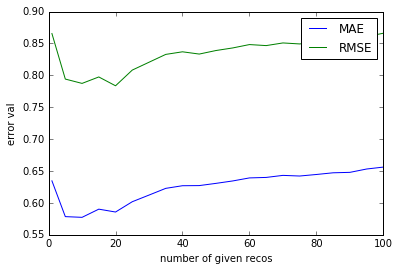

In [159]:
##
##  graph error score with number of recommended items as dependent variable
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of given recos')

plt.show()

In [160]:
## MAE score vs. number of recos

np.column_stack ([np_arr,mae_array])[0:10]

array([[  1.        ,   0.63460855],
       [  5.        ,   0.57850429],
       [ 10.        ,   0.57737749],
       [ 15.        ,   0.59021533],
       [ 20.        ,   0.58572518],
       [ 25.        ,   0.6018656 ],
       [ 30.        ,   0.6122942 ],
       [ 35.        ,   0.62283007],
       [ 40.        ,   0.62696344],
       [ 45.        ,   0.62716411]])

In [161]:
np_arr = np.arange(5,101,5)
np_arr = np.concatenate([np.array([1]),np_arr])
print (np_arr)

[  1   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]


In [162]:
##  SVD score versus number of vectors
##

mae_array = []
rmse_array = []

for k_value in np_arr:
    
    print "K value: ", k_value
    svd.compute(k=k_value, min_values=5, pre_normalize=None, mean_center=True, post_normalize=True)
    mae_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = 30, pow_val = 1)
    rmse_error_val = get_error_score_for_test_data (prefs_test, prefs_train, movies_list=movies_list, itemsim = svd, n_reco = 30, pow_val = 2)
    print mae_error_val, rmse_error_val
    mae_array +=[mae_error_val]
    rmse_array +=[rmse_error_val]
    

K value:  1
0.640364182749 0.857912280902
K value:  5
0.605082433274 0.810178678994
K value:  10
0.612294202324 0.820594415744
K value:  15
0.618680391814 0.831867740177
K value:  20
0.617716349686 0.833282866615
K value:  25
0.630267568791 0.850358907356
K value:  30
0.628658523235 0.850837623264
K value:  35
0.626925105672 0.851696694757
K value:  40
0.622770660452 0.846493365094
K value:  45
0.626246063589 0.838878425415
K value:  50
0.63002058234 0.843521804923
K value:  55
0.631395616313 0.851764416838
K value:  60
0.639843199614 0.865346960527
K value:  65
0.630979326779 0.856804114891
K value:  70
0.629800097168 0.851547769001
K value:  75
0.620577305777 0.837551600167
K value:  80
0.626262059029 0.84897668225
K value:  85
0.625270763574 0.849291834585
K value:  90
0.632071739683 0.851636586893
K value:  95
0.625118931309 0.83820004993
K value:  100
0.626580231333 0.841810914993


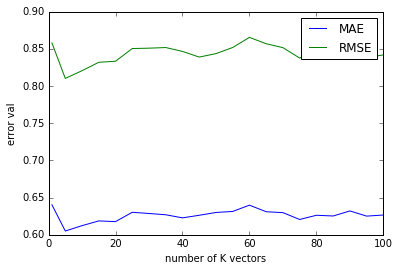

In [163]:
##
##  Graph user based recommendations errors
##

plt.plot(np_arr, mae_array, label='MAE')
plt.plot(np_arr, rmse_array, label = 'RMSE')

plt.legend()
plt.ylabel('error val')
plt.xlabel('number of K vectors')

plt.show()

In [164]:
## Минимум продолжает уменьшаться при увеличении количества пользователей.

np.column_stack ([np_arr,mae_array])[0:10]

array([[  1.        ,   0.64036418],
       [  5.        ,   0.60508243],
       [ 10.        ,   0.6122942 ],
       [ 15.        ,   0.61868039],
       [ 20.        ,   0.61771635],
       [ 25.        ,   0.63026757],
       [ 30.        ,   0.62865852],
       [ 35.        ,   0.62692511],
       [ 40.        ,   0.62277066],
       [ 45.        ,   0.62624606]])

#### Результат:

SVD показывает на данных MovieLens результаты намного лучше, чем коллаборативная фильтрация. MAE ниже - 0.6 против 0.82 и RMSE 0.85 против 1.1 для 100 соседей (user-based)